In [1]:
import scanpy as sc

In [2]:
import pickle

In [3]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
import sys
import os
from importlib import reload

# Add the path of your package
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/GlossPath/")
sys.path.insert(0, package_path)
package_path = os.path.abspath("/Genomics/pritykinlab/tamjeed/github_packages/Gloss/")
sys.path.insert(0, package_path)

In [7]:
def generate_pathways_dict(fn, mygenes, change_case = False):
    pathways = {}
    with open(fn, "r") as f:
        for line in f:
            line = line.strip()
            words = line.split("\t")
            if change_case:
                words = [ word.capitalize() for word in words]
            pathway = words[2:]
            pathway = list(set(pathway).intersection(mygenes))
            pathways[words[0]] = pathway
            #if len(pathway) < 200 and len(pathway) > 3:
            #    pathways[words[0]] = pathway
    return pathways

In [8]:
def get_hallmark_pathways(gene_ad):
    hallmark_pathways_path = '../pathway_collections/mouse_hallmark_genes.gmt.txt'
    mygenes = set(gene_ad.var.index)
    path_dict = generate_pathways_dict(hallmark_pathways_path, mygenes)
    return path_dict

def get_kegg_pathways(gene_ad):
    with open('../pathway_collections/kegg_pathways_sep18_2024.pkl', 'rb') as handle:
        kegg_gene_sets = pickle.load(handle)
    
    mygenes = set(gene_ad.var.index)
    for key, value in kegg_gene_sets.items():
        kegg_gene_sets[key] = list(set([gene for gene in value if gene in mygenes]))
        
    empty = []
    for key in kegg_gene_sets:
        if not kegg_gene_sets[key]:
            empty.append(key)

    for pathway in empty:
        kegg_gene_sets.pop(pathway)
        
    path_dict = kegg_gene_sets
    return path_dict

In [9]:
with open('../pathway_computations/cellchatdb.pickle', 'rb') as handle:
    cellchatdb = pickle.load(handle)
with open('../pathway_computations/cd40neighbors.pickle', 'rb') as handle:
    cd40neighbors = pickle.load(handle)

In [10]:
with open('../pathway_computations/random_neighbors.pickle', 'rb') as handle:
    random_neighbors = pickle.load(handle)

In [11]:
with open('../pathway_computations/humanbase_cd40neighbors.pickle', 'rb') as handle:
    humanbase_cd40neighbors = pickle.load(handle)

In [12]:
with open('../pathway_computations/cd40_filtered.pickle', 'rb') as handle:
    cd40_filtered_neighbors = pickle.load(handle)

In [13]:
with open('../pathway_computations/combined_cellchatdb_nn_signaling.pickle', 'rb') as handle:
    combined_c_n = pickle.load(handle)

In [14]:
from GlossPath.prepdata import PrepData

In [15]:
prepped_datas = {}
for i in range(10):
    print(i)
    datapath = 'datasets/{}_lcmv_ln_data_perturbed_combined_c_n_v2_oct_26_2024.h5ad'.format(i)
    prepped_datas[i] = PrepData(datapath, 'hallmark', 'sample count', 'total_counts', 'biotin_raw_perturbed', donors_profiled=True)

0
1
2
3
4
5
6
7
8
9


In [16]:
lcmv_adatas = {}
for i in range(10):
    lcmv_adatas[i] = prepped_datas[i].adata

In [17]:
datasets = {
    #'gut' : gut_adatas,
    'lcmv_ln' : lcmv_adatas,
    #'lcmv_ln' : lcmv_ln_ad,
    #'l_tumor' : l_tumor_adatas,
}

In [18]:
datasets['lcmv_ln']

{0: AnnData object with n_obs × n_vars = 8268 × 11558
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'likely sample', 'biotin_interaction', 'biotin_donor', 'biotin sample', 'sample count', 'cell_norm_biotin', 'cell_norm_donor', 'sample_lane', 'timepoint', 'infection', 'sample origin', 'leiden', 'annot', 'cell', 'og annot', 'donor', 'log normalized biotin', 'normalized biotin', 'interactor', ' donor ', ' interactor ', ' normalized biotin ', 'donor_cat', 'interactor_cat', 'new_biotin', 'other_new_biotin', 'log_sample_hashtag', 'log_RNA_libsize', 'biotin_raw_perturbed'
     var: 'n_counts', 'mean', 'std'
     uns: ' donor _colors', ' interactor _colors', 'annot_colors', 'leiden', 'leiden_colors', 'likely sample_colors', 'log1p', 'neighbors', 'pca', 'sample_lane_colors', 'timepoint_colors', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'log_lib_norm', 'raw_counts', 'theta_1', 'log_scaled'
     obsp: 'connectivities', 'dista

In [19]:
## coefficients

# uLIPSTIC gut
#with open('../model_ulipstic_gut/experiment_evaluations/gut_glosspath_bootstrap_hallmark_oct9_2024.pickle', 'rb') as handle:
#    gut_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv sys
#with open('../model_ulipstic_lcmv/experiment_evaluations/', 'rb') as handle:
#    lcmv_sys_glasso_res = pickle.load(handle)
# uLIPSTIC lcmv ln
#with open('../model_ulipstic_lcmv/experiment_evaluations/grouplasso_hallmark_bootstrap_u_lcmv_ln_oct3_2024.pickle', 'rb') as handle:
#    lcmv_ln_glasso_res = pickle.load(handle)
# LIPSTIC tumor

lcmv_ln_perturb_bootstraps = {}
for i in range(10):
    print(i)
    with open('../model_ulipstic_lcmv/experiment_evaluations/{}_lcmv_ln_perturbed_new_gloss_bootstrap_hallmark_oct26_2024.pickle'.format(i), 'rb') as handle:
        lcmv_ln_perturb_bootstraps[i] = pickle.load(handle)

0
1
2
3
4
5
6
7
8
9


In [20]:
lcmv_coefficient_results = {}
for i in range(10):
    lcmv_coefficient_results[i] = lcmv_ln_perturb_bootstraps[i].response_individual_genes

In [21]:
coefficient_results = {
    'lcmv_ln' : lcmv_coefficient_results,
    #'lcmv_ln' : lcmv_ln_glasso_res,
    #'gut' : gut_coefficient_results
}

In [22]:
resolution_subsets = {

'lcmv_ln' : {
    'annot' : ['Cd4']
}

}

In [23]:
def make_corr_df(ad, norm_layer, biotin_norm=False):
    genes = ad.var_names
    spearman_rhos = []
    gene_vals = ad.layers[norm_layer].toarray()
    print(gene_vals.shape)
    if not biotin_norm:
        biotin_vals = ad.obs['new_biotin']
    else:
        biotin_vals = ad.obs['other_new_biotin']
    for i, g in enumerate(genes):
        mygene = gene_vals[:,i]
        spearman_rhos.append(spearmanr(biotin_vals, mygene))
    df = pd.DataFrame({"gene": genes, 
                       "corr": [ c[0] for c in spearman_rhos],
                       "sig": [ c[1] for c in spearman_rhos],
                      })
    
    df["top gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=10)["gene"]) + 
    list(df.sort_values("corr", ascending=True).head(n=10)["gene"]))
    df["top 30 corr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=False).head(n=30)["gene"]))
    df["top 30 anticorr gene"] = df.gene.isin(
    list(df.sort_values("corr", ascending=True).head(n=30)["gene"]))
    df = df.sort_values("corr") 
    df["i"] = [i/10 for i in range(len(genes))]
    
    df['is_FDR_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[0]
    df['corrected_sig'] = multipletests(df['sig'], method='bonferroni', alpha=0.01)[1]
    df.dropna(inplace=True)
    return df

In [24]:
datasets['lcmv_ln']

{0: AnnData object with n_obs × n_vars = 8268 × 11558
     obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'likely sample', 'biotin_interaction', 'biotin_donor', 'biotin sample', 'sample count', 'cell_norm_biotin', 'cell_norm_donor', 'sample_lane', 'timepoint', 'infection', 'sample origin', 'leiden', 'annot', 'cell', 'og annot', 'donor', 'log normalized biotin', 'normalized biotin', 'interactor', ' donor ', ' interactor ', ' normalized biotin ', 'donor_cat', 'interactor_cat', 'new_biotin', 'other_new_biotin', 'log_sample_hashtag', 'log_RNA_libsize', 'biotin_raw_perturbed'
     var: 'n_counts', 'mean', 'std'
     uns: ' donor _colors', ' interactor _colors', 'annot_colors', 'leiden', 'leiden_colors', 'likely sample_colors', 'log1p', 'neighbors', 'pca', 'sample_lane_colors', 'timepoint_colors', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'log_lib_norm', 'raw_counts', 'theta_1', 'log_scaled'
     obsp: 'connectivities', 'dista

In [25]:
corr_results = {}

for i in range(10):
    print(i)
    corr_results[i] = {}
    for data in resolution_subsets:
        print(data)
        corr_results[i][data] = {}
        for resolution in resolution_subsets[data]:
            corr_results[i][data][resolution] = {}
            for ctype in resolution_subsets[data][resolution]:
                corr_results[i][data][resolution][ctype] = make_corr_df(datasets[data][i][datasets[data][i].obs[resolution] == ctype], norm_layer='log_lib_norm', biotin_norm=True)

0
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


1
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


2
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


3
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


4
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


5
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


6
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


7
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


8
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


9
lcmv_ln
(3292, 11558)


/Genomics/argo/users/ta4188/.conda/envs/xenium/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [42]:
corr_results[0]['lcmv_ln']['annot']['Cd4']

,gene,corr,sig,top gene,top 30 corr gene,top 30 anticorr gene,i,is_FDR_sig,corrected_sig
5399,Junb,-0.252999,3.023405e-49,True,False,True,0.0,True,3.494452e-45
5297,Bst2,-0.249520,6.599676e-48,True,False,True,0.1,True,7.627906e-44
2851,Isg15,-0.245247,2.728796e-46,True,False,True,0.2,True,3.153942e-42
7894,Rsad2,-0.241438,7.085610e-45,True,False,True,0.3,True,8.189549e-41
11033,Ifit3,-0.241252,8.294120e-45,True,False,True,0.4,True,9.586343e-41
...,...,...,...,...,...,...,...,...,...
4526,Rps11,0.159776,2.886038e-20,True,True,False,1134.9,True,3.335682e-16
7076,Tcf7,0.160814,1.634842e-20,True,True,False,1135.0,True,1.889551e-16
6842,Rpl41,0.172988,1.569807e-23,True,True,False,1135.1,True,1.814383e-19
10855,Fau,0.176996,1.420479e-24,True,True,False,1135.2,True,1.641790e-20


In [27]:
dataset = 'lcmv_ln'
res = 'annot'
ctype = 'Cd4'

In [28]:
i = 0

In [29]:
# filter a dict to only include genes in that data

test_ad = datasets[dataset][i]
coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
corr = corr_results[i][dataset][res][ctype]

# run the enrichment over correlations or coefficients

In [43]:
mycoefs = coef 
mycoefs.columns[-50:]

Index(['Fas', 'Vdac3', 'Sgk1', 'H2-D1', 'Prdx3', 'Ldhb', 'Myh9', 'Lysmd2',
       'Phb2', 'Ncoa4', 'Akt2', 'Riok3', 'Grpel1', 'Ap2m1', 'Eif3j1',
       'Aldh6a1', 'Ly6e', 'Psme2', 'Pmepa1', 'Casp8', 'Trim12c', 'Il7r', 'B2m',
       'Ets1', 'Icam2', 'Prdx2', 'Ldha', 'Bmp2', 'Mapk14', 'Tap1', 'Helz2',
       'Nf2', 'Arl4a', 'Psma3', 'Myc', 'Zfp36', 'Csf1', 'Lck', 'Mov10', 'Jun',
       'Psmb9', 'Traf1', 'Cd47', 'Icam1', 'Ifi27', 'Arid5b', 'Ifngr1', 'Bcl3',
       'Ptprc', 'Socs3'],
      dtype='object')

In [45]:
corr

,gene,corr,sig,top gene,top 30 corr gene,top 30 anticorr gene,i,is_FDR_sig,corrected_sig
5399,Junb,-0.261585,1.219034e-52,True,False,True,0.0,True,1.408959e-48
3367,Vps37b,-0.241462,6.946126e-45,True,False,True,0.1,True,8.028332e-41
5297,Bst2,-0.241212,8.579724e-45,True,False,True,0.2,True,9.916445e-41
2851,Isg15,-0.240522,1.537566e-44,True,False,True,0.3,True,1.777118e-40
2208,Pnrc1,-0.237393,2.116420e-43,True,False,True,0.4,True,2.446158e-39
...,...,...,...,...,...,...,...,...,...
7076,Tcf7,0.158134,7.033032e-20,True,True,False,1134.9,True,8.128778e-16
4526,Rps11,0.158580,5.528698e-20,True,True,False,1135.0,True,6.390069e-16
6842,Rpl41,0.171432,3.930098e-23,True,True,False,1135.1,True,4.542408e-19
10855,Fau,0.171578,3.607076e-23,True,True,False,1135.2,True,4.169058e-19


In [31]:
mypathdict = {}
mypathdict.update(cd40neighbors.copy())
mypathdict.update(cellchatdb.copy())
mypathdict.update(humanbase_cd40neighbors.copy())
mypathdict.update(random_neighbors.copy())
mypathdict.update(cd40_filtered_neighbors.copy())
mypathdict.update(combined_c_n.copy())

for key in mypathdict:
    mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))

In [32]:
mypathdict

{'cd40_and_neighbors': ['Cdc37',
  'Polr2h',
  'Lyn',
  'Cbx3',
  'Cdc25c',
  'Scarb2',
  'Pdcd1',
  'Slc39a13',
  'Tnfrsf13b',
  'Ogt',
  'Nedd4',
  'Chuk',
  'Guk1',
  'Ncoa6',
  'Caml',
  'Ddx3x',
  'Entpd6',
  'Tmem147',
  'Rara',
  'Actg1',
  'Adora2a',
  'Jak3',
  'Cd79a',
  'Dctn2',
  'Pik3r6',
  'Sgk1',
  'Zhx2',
  'Selp',
  'Ptafr',
  'Rfc5',
  'Diablo',
  'Tpt1',
  'Cep83',
  'Tmem128',
  'Tnfrsf4',
  'Ltbr',
  'Tmed7',
  'Scarb1',
  'Gusb',
  'Lrp1',
  'Rnf4',
  'Pik3ca',
  'Gorasp1',
  'Rnf31',
  'Gca',
  'Aff3',
  'Btla',
  'Sv2a',
  'Pou2f2',
  'Cd27',
  'Fig4',
  'Mag',
  'Insig2',
  'Pcmt1',
  'Ripk1',
  'Pou2f1',
  'Map2k7',
  'Tnfrsf11a',
  'Katna1',
  'Slc39a7',
  'Plec',
  'Mybbp1a',
  'Antxr2',
  'Bcr',
  'Htra2',
  'Myd88',
  'Mfsd5',
  'Map3k7',
  'Cyb561a3',
  'Fbl',
  'Slc30a7',
  'Ptprc',
  'Casp2',
  'Cd40lg',
  'Ung',
  'Tnfrsf18',
  'Fyn',
  'Il2ra',
  'Cdc37l1',
  'Cd19',
  'Itgb1bp1',
  'Hspa1b',
  'Cd244a',
  'Eif2ak2',
  'Crebbp',
  'Jak2',
  'Ripk2',
 

In [33]:
import gseapy as gp

# Define your custom local gene sets as a dictionary
gene_sets = mypathdict

In [34]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'combined_c_n'])

In [35]:
pos_coef_dict = {}
pos_corr_dict = {}

pos_coef_sig_dict = {}

for i in range(10):
    print(i)
    
    test_ad = datasets[dataset][i]
    coef = coefficient_results[dataset][i][res][ctype].drop('log', axis=1)
    corr = corr_results[i][dataset][res][ctype]
    
    mycoefs = coef 
    
    mypathdict = {}
    mypathdict.update(cd40neighbors.copy())
    mypathdict.update(cellchatdb.copy())
    mypathdict.update(humanbase_cd40neighbors.copy())
    mypathdict.update(random_neighbors.copy())
    mypathdict.update(cd40_filtered_neighbors.copy())
    mypathdict.update(combined_c_n.copy())

    for key in mypathdict:
        mypathdict[key] = list(set(mypathdict[key]).intersection(test_ad.var.index))
    
    pos_coef_dict[i] = {}
    pos_corr_dict[i] = {}

    pos_coef_sig_dict[i] = {}

    for key in mypathdict:
        pos_coef_dict[i][key] = []
        pos_corr_dict[i][key] = []
        pos_coef_sig_dict[i][key] = []

    for total_genes in range(50, 1010, 10):

        gene_list = list(mycoefs.columns[-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        genr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(genr.results['Term'], genr.results['Overlap']))
        overlap_sig_res = dict(zip(genr.results['Term'], genr.results['P-value']))
        for key in gene_sets:
            if key in overlap_res:
                pos_coef_dict[i][key].append(int(overlap_res[key].split('/')[0]))
                pos_coef_sig_dict[i][key].append(overlap_sig_res[key])
            else:
                pos_coef_dict[i][key].append(0)
                pos_coef_sig_dict[i][key].append(1.0)

        overlap_res

        gene_list = list(corr['gene'][-total_genes:])

        # Run the Overrepresentation Test using your custom gene sets
        cenr = gp.enrichr(gene_list=gene_list, 
                         gene_sets=gene_sets,  # Use the local gene sets
                         outdir=None,
                         organism='Mouse',
                         cutoff=1.0,  # Adjust p-value cutoff as needed
                         background=list(test_ad.var.index)
                        )

        overlap_res = dict(zip(cenr.results['Term'], cenr.results['Overlap']))
        for key in gene_sets:
            if key in overlap_res:
                pos_corr_dict[i][key].append(int(overlap_res[key].split('/')[0]))
            else:
                pos_corr_dict[i][key].append(0)

0
1
2
3
4
5
6
7
8
9


In [36]:
mypathdict.keys()

dict_keys(['cd40_and_neighbors', 'ligands', 'receptors', 'ligrec', 'hb_macrophage_cd40', 'hb_dc_cd40', 'Rsl1', 'Gm25597', 'Calml3', 'Cdkl5', 'Ajuba', 'Kif17', 'Fbxw18', 'Dynlt1b', 'Runx1', 'Kansl1l', 'Jaml', 'Itgae', 'Nkg7', 'Actn2', 'Ccl5', 'Id2', 'Gzma', 'Cd160', 'cd40_f_in', 'cd40_f_out', 'cd40_f_union', 'cd40_f_intersection', 'combined_c_n'])

In [37]:
mykey = 'combined_c_n'

In [38]:
myindex = 45
coef_overlap = []
corr_overlap = []
for i in range(10):
    coef_overlap.append(pos_coef_dict[i][mykey][myindex])
    corr_overlap.append(pos_corr_dict[i][mykey][myindex])

coef_overlap

corr_overlap

mydf = pd.DataFrame({'Gloss' : coef_overlap, 'Corr.' : corr_overlap})

from scipy.stats import ttest_rel
mytres = ttest_rel(mydf['Gloss'], mydf['Corr.'])[1]

Text(0.5, 1.0, 'uLIPSTIC LCMV LN CD4 T\n($p = $3.42e-10, 500 Genes)')

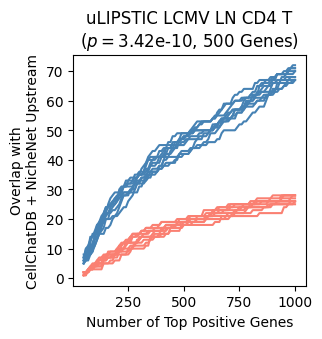

In [39]:
plt.figure(figsize=(3,3))
for i in range(10):
    plt.plot(list(range(50, 1010, 10)), pos_coef_dict[i][mykey], label='Gloss Hallmark', color='steelblue')
    plt.plot(list(range(50, 1010, 10)), pos_corr_dict[i][mykey], label='Correlations', color='salmon')
plt.xlabel('Number of Top Positive Genes')
plt.ylabel('Overlap with\nCellChatDB + NicheNet Upstream'.format(mykey))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=3)
plt.title(f'uLIPSTIC LCMV LN CD4 T\n($p = ${mytres:.2e}, 500 Genes)'.format(ctype))